## Setup

Import modules

In [948]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport
import sweetviz as sv

Define constants and import dataset

In [949]:
DATASET = '../udataset/filtered_stock_and_etfs.csv'

df = pd.read_csv(DATASET)

## Exploratory Data Analysis

Generate Profile report for the dataset using `ydata-profiling` library

Generate a profile report using the `sweetviz` library

Plot time series data of coca cola stock

Plot time series data of S&P500 index

## Create metric for growth

Convert the date column to date type

In [950]:
df['Date-Time'] = pd.to_datetime(df['Date-Time'])
df['YearMonth'] = df['Date-Time'].dt.to_period('Y')

Sort the dataframe by ticker symbol and date

In [951]:
df = df.sort_values(by=['Ticker_Symbol', 'Date-Time'])

Get the monthly opening price for each stock and the opening price the previous month

In [952]:
month_open_prices = df.groupby(['Ticker_Symbol', 'YearMonth'])['Open'].first().reset_index()

month_open_prices['Prev_First_Open'] = month_open_prices.groupby('Ticker_Symbol')['Open'].shift(1)

Calculate the monthly growth for each stock

In [953]:
month_open_prices['Monthly_Growth (%)'] = ((month_open_prices['Open'] - month_open_prices['Prev_First_Open']) / month_open_prices['Prev_First_Open']) * 100

Calculate the cumulative monthly growth for each stock

In [954]:
month_open_prices['Cumulative_Growth (%)'] = month_open_prices.groupby('Ticker_Symbol')['Monthly_Growth (%)'].cumsum()

Drop the first row of each stock

In [955]:
growth = month_open_prices.dropna(subset=['Prev_First_Open'])
growth['YearMonth']-=1

growth.to_csv('../udataset/stock_growth.csv', index=False)

/tmp/ipykernel_26528/4255637271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth['YearMonth']-=1


## Plot growth for each symbol

/tmp/ipykernel_26528/2075753244.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display_data['YearMonth_str'] = display_data['YearMonth'].astype(str)
/home/cdv/Datathon/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cdv/Datathon/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cdv/Datathon/.venv/lib/python3.10/site-pac

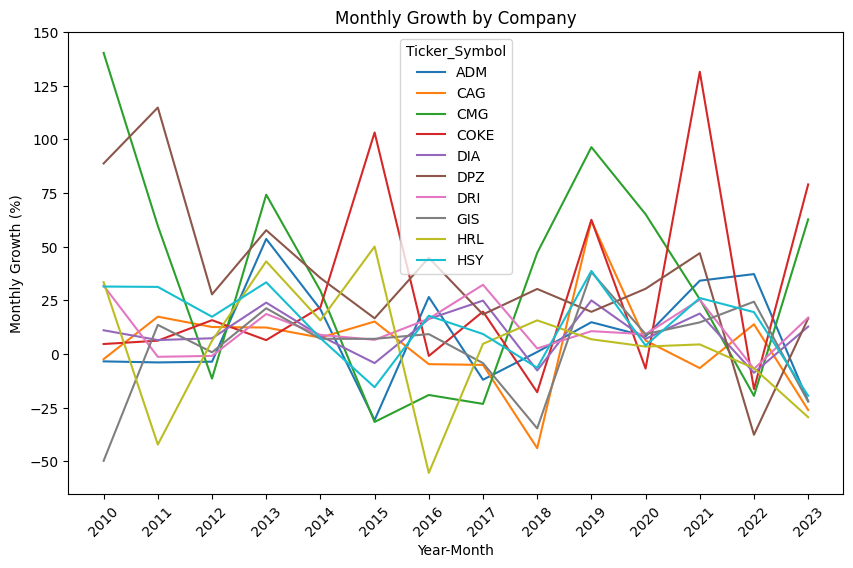

In [956]:
display_data = growth[growth['YearMonth'] >= pd.Period('2010')]

display_data['YearMonth_str'] = display_data['YearMonth'].astype(str)

company_subset = display_data['Ticker_Symbol'].unique()[:10] # First 10 companies
plot_data = display_data[display_data['Ticker_Symbol'].isin(company_subset)]


plt.figure(figsize=(10, 6)) # TODO - Note that graph is not well labeled
sns.lineplot(data=plot_data, x='YearMonth_str', y='Monthly_Growth (%)', hue='Ticker_Symbol')
plt.xticks(rotation=45)
plt.title('Monthly Growth by Company')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Growth (%)')
plt.show()

In [957]:
MARKETCAP = '../udataset/market_cap.csv'
cap_df = pd.read_csv(MARKETCAP)

In [958]:
def get_market_cap(row):
    to_return = cap_df[(cap_df['year'] == row['YearMonth']) & (cap_df['ticker'] == row['Ticker_Symbol'])]['market_cap_M']
    to_return = np.array(to_return)

    if len(to_return) == 0:
        return pd.NA

    to_return = to_return[0]
    return to_return

In [959]:
#print(growth[(growth['Ticker_Symbol'] == 'QSR') & (growth['YearMonth'] == pd.Period('2015'))])
cap_df['year'] = pd.to_datetime(cap_df['year'], format='%Y')
cap_df['year'] = cap_df['year'].dt.to_period('Y')
growth = growth[growth['YearMonth'] >= pd.Period('2010')]
growth['market_cap'] = growth.apply(get_market_cap, axis=1)

In [960]:
growth['market_cap_growth'] = growth['market_cap']*growth['Monthly_Growth (%)']

In [961]:
growth

,Ticker_Symbol,YearMonth,Open,Prev_First_Open,Monthly_Growth (%),Cumulative_Growth (%),market_cap,market_cap_growth
12,ADM,2010,30.39,31.48,-3.462516,127.822744,19160.0,-66341.80432
13,ADM,2011,29.19,30.39,-3.948667,123.874077,19100.0,-75419.545903
14,ADM,2012,28.14,29.19,-3.597122,120.276954,18050.0,-64928.057554
15,ADM,2013,43.22,28.14,53.589197,173.866151,28600.0,1532651.030561
16,ADM,2014,52.20,43.22,20.777418,194.643569,33120.0,688148.079593
...,...,...,...,...,...,...,...,...
551,YUM,2019,100.90,91.09,10.769569,162.647480,30210.0,325348.666154
552,YUM,2020,109.02,100.90,8.047572,170.695052,32740.0,263477.502478
553,YUM,2021,138.38,109.02,26.930838,197.625890,40700.0,1096085.121996
554,YUM,2022,128.42,138.38,-7.197572,190.428318,36070.0,-259616.418558


In [962]:
overall_growth = []
for year in range(2010, 2023):
    overall_growth.append(growth[growth['YearMonth'] == pd.Period(str(year))]['market_cap_growth'].sum()/growth[growth['YearMonth'] == pd.Period(str(year))]['market_cap'].sum())

new_df = pd.DataFrame({'year': list(range(2010, 2023)), 
    'processed_food_growth': overall_growth, 
    'S&P_growth': growth[(growth['Ticker_Symbol'] == 'SPY') & 
    (growth['YearMonth'] >= pd.Period('2010')) & 
    (growth['YearMonth'] <= pd.Period('2022'))]['Monthly_Growth (%)']})
new_df['growth_diff'] = ((new_df['processed_food_growth'] - new_df['S&P_growth']))
new_df

,year,processed_food_growth,S&P_growth,growth_diff
397,2010,16.129403,12.761413,3.367990
398,2011,19.070586,0.828664,18.241922
399,2012,2.933312,13.580150,-10.646838
400,2013,26.602131,26.786576,-0.184445
401,2014,10.635013,12.175236,-1.540224
402,2015,2.523951,-2.853959,5.377910
403,2016,3.899727,12.245000,-8.345273
404,2017,18.186791,19.018841,-0.832050
405,2018,-2.388598,-8.161589,5.772992
406,2019,30.121168,31.531019,-1.409851


In [963]:
UNEMPLOYMENTDATA = '../udataset/acs/unemployment.csv'
unemployment_df = pd.read_csv(UNEMPLOYMENTDATA)
unemployment_df.columns = unemployment_df.columns.str.strip()

In [964]:
unemployment_rate = []
for year in range(2010, 2023):
    unemployment_rate.append(unemployment_df[unemployment_df['year'] == year]['estimate'].sum()/unemployment_df[unemployment_df['year'] == year]['labour_force_pop'].sum()*100)
    #unemployment_rate.append(unemployment_df[unemployment_df['year'] == year]['estimate'].sum())


In [965]:
#unemployment_rate = [9.63, 8.95, 8.07, 7.37, 6.17, 5.28, 4.87, 4.36, 3.90, 3.67, 8.05, 5.35, 3.61]
new_df['unemployment_rate'] = unemployment_rate
print(new_df['unemployment_rate'].expanding().corr(new_df['S&P_growth']))
print(new_df.corr())

397         NaN
398   -1.000000
399   -0.015120
400    0.576600
401    0.553582
402    0.651783
403    0.437893
404    0.086141
405    0.444405
406   -0.022069
407   -0.068452
408   -0.189914
409    0.074696
dtype: float64
                           year  processed_food_growth  S&P_growth  \
year                   1.000000              -0.075102   -0.082555   
processed_food_growth -0.075102               1.000000    0.783228   
S&P_growth            -0.082555               0.783228    1.000000   
growth_diff            0.047014              -0.121486   -0.712281   
unemployment_rate     -0.875614               0.003108    0.074696   

                       growth_diff  unemployment_rate  
year                      0.047014          -0.875614  
processed_food_growth    -0.121486           0.003108  
S&P_growth               -0.712281           0.074696  
growth_diff               1.000000          -0.115742  
unemployment_rate        -0.115742           1.000000  


In [966]:
new_df.to_csv('../udataset/growth_vs_unemployment.csv')